In [26]:
## imports ##
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle as pkl
import MFTime
import MFParse
import os
import scipy.signal
####

## global ##
dataPath='/Users/ziegler/repos/mayfly/output/timeSeries1252021.pkl'
simPath='/Users/ziegler/p8/egg_files/eggsTemplates1252021/'
templatePitchAngles=np.linspace(85,90,51)
templatePos=np.linspace(0,5e-2,21)
radius=0.00
#nPeaks=5
nTest=256
noiseVar=2.3e-14
colors=['r','b','g','c','m','k']
frequencyConversion=200e6/8192
array_rad=0.1
Vrange=(80-280*array_rad+300*array_rad**2)*1e-9
nSlice=2
sliceSize=8192
samplePeriod=5e-9
time=np.arange(0,sliceSize)
####

## definitions ##

def getEggFilePaths(dirPath,listOfPaths):
    try:
        os.path.isdir(dirPath)
    except:
        return False

    for fPath in os.listdir(dirPath):
        if fPath.split('.')[-1]=='egg':
            listOfPaths.append(os.path.join(dirPath,fPath))

    return True

def getEggFileParams(eggPath,params):
    try:
        os.path.isfile(eggPath)
    except:
        return False

    try:
        pitchAngle=float(eggPath.split('/')[-1].split('Angle')[-1].split('_')[0])
        radius=float(eggPath.split('/')[-1].split('Pos')[-1].split('.egg')[0])
    except:
        return False

    params.append(pitchAngle)
    params.append(radius)

    return True

def getSimpleTemplate(frequencies,amplitudes,relPhase,nSample,dT):

    simpleTemplate=np.zeros(nSample,dtype=np.complex128)
    time=np.arange(0,nSample,1)*dT
    maxAmplitude=np.argmax(amplitudes)
    for i in range(len(frequencies)):
        if i == maxAmplitude:
            simpleTemplate+=amplitudes[i]*np.exp(+1j*2*np.pi*(frequencies[i]*time))
        else:
            simpleTemplate+=amplitudes[i]*np.exp(+1j*2*np.pi*(frequencies[i]*time+relPhase))

    return simpleTemplate

def addNoise(input,var):

    noise=np.random.multivariate_normal([0,0],np.eye(2)*var/2,len(input))
    noise=noise[:,0]+1j*noise[:,1]

    return input+noise

def getSimpleFrequencyEstimate(frequencySeries,threshold=0.25):

    maxValue=np.max(abs(frequencySeries))
    maxInd=np.argmax(abs(frequencySeries))
    #print(maxInd)

    rawPeakInds=np.where(abs(frequencySeries)>threshold*maxValue)[0]
    
    bigPeakInd=np.flip(np.argsort(abs(frequencySeries)))[0:10]
    bigPeakAmp=abs(frequencySeries[bigPeakInd])
    
    groupedPeakIndInd=np.argsort(bigPeakInd)
    
    groupedPeakInd=bigPeakInd[groupedPeakIndInd]
    groupedPeakAmp=bigPeakAmp[groupedPeakIndInd]

    return groupedPeakInd,groupedPeakAmp

####


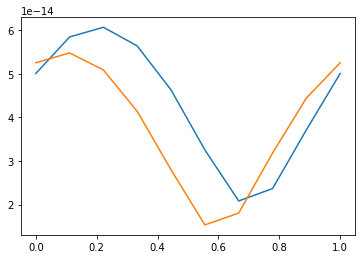

press enter


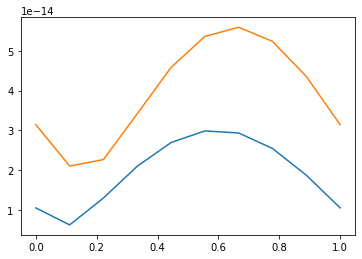

press enter
/Users/ziegler/p8/egg_files/eggsTemplates1252021/locust_mc_Seed600_Angle86.10_Pos0.043.egg


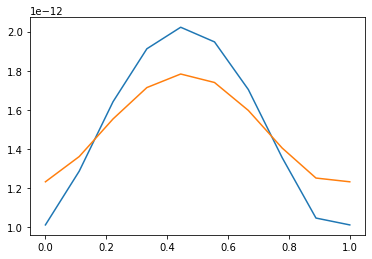

press enter


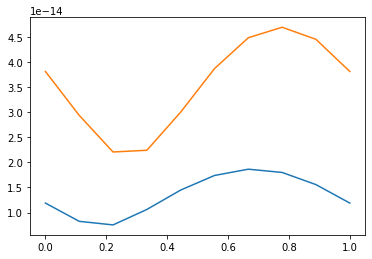

press enter


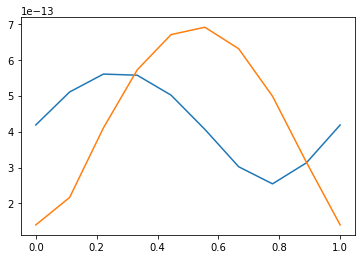

press enter


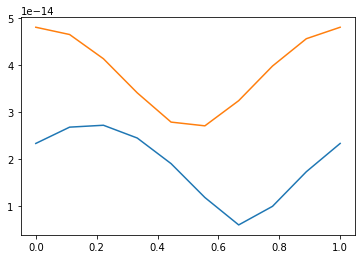

press enter
/Users/ziegler/p8/egg_files/eggsTemplates1252021/locust_mc_Seed605_Angle89.30_Pos0.037.egg


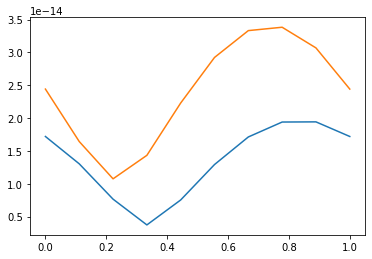

press enter


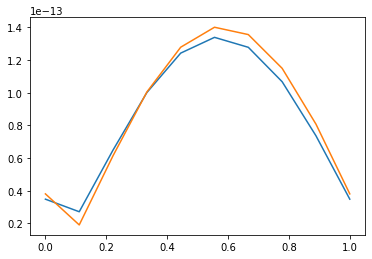

press enter


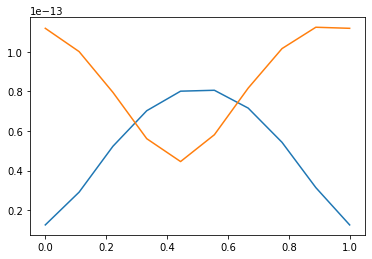

press enter


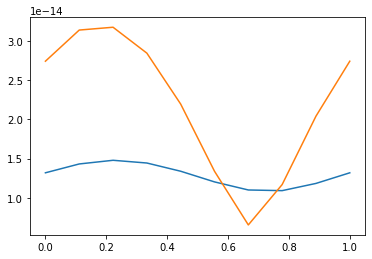

press enter


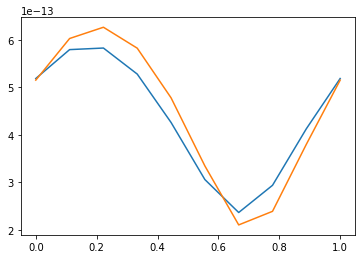

press enter


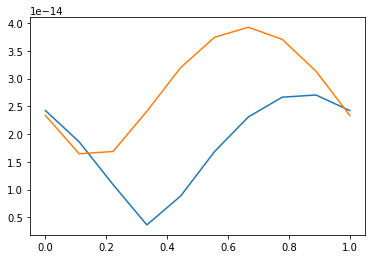

press enter


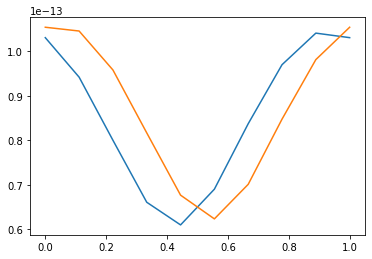

press enter


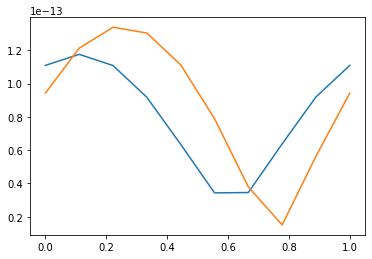

press enter


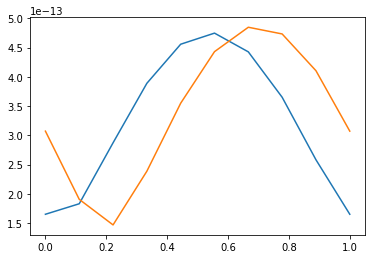

press enter
/Users/ziegler/p8/egg_files/eggsTemplates1252021/locust_mc_Seed601_Angle86.20_Pos0.000.egg


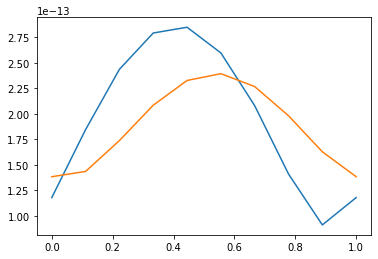

press enter


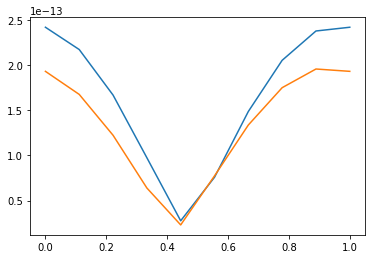

press enter
/Users/ziegler/p8/egg_files/eggsTemplates1252021/locust_mc_Seed600_Angle87.00_Pos0.000.egg


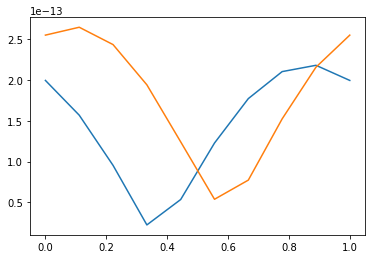

press enter
/Users/ziegler/p8/egg_files/eggsTemplates1252021/locust_mc_Seed600_Angle87.00_Pos0.028.egg


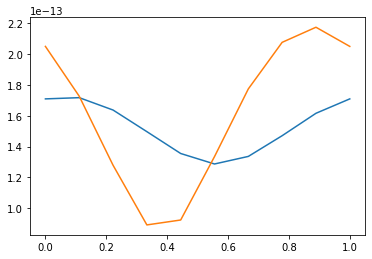

press enter
/Users/ziegler/p8/egg_files/eggsTemplates1252021/locust_mc_Seed608_Angle89.60_Pos0.025.egg


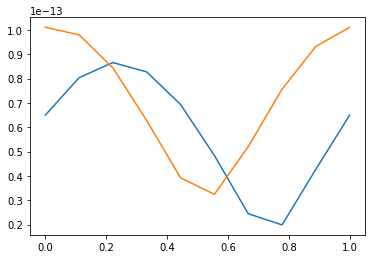

press enter


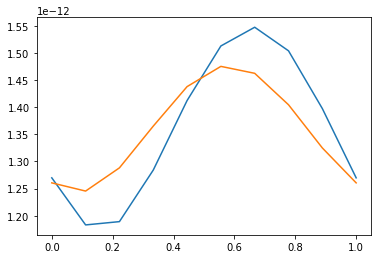

KeyboardInterrupt: Interrupted by user

In [42]:
eggPaths=[]
badEgg=[]
relativeMean=[]
if getEggFilePaths(simPath,eggPaths): # put all the found egg files into a list
    #print('test')
    for eggPath in eggPaths: # iterate over the simulation files

        simulationParams=[]
        getEggFileParams(eggPath,simulationParams)

        eggDataTime=MFParse.parse_egg(eggPath,Vrange=Vrange)
        eggSliceTime=MFParse.slice_egg(eggDataTime,nSlice,sliceSize)

        if MFParse.check_egg_slice(eggSliceTime): # check if the simulation is broken
            badEgg.append(eggPath)
            print(eggPath)
        else:
            tempDict={}

            eggSliceFFT,FFTFrequencies=MFTime.katydid_fft(eggSliceTime)
            trueSignalTime=eggSliceTime[0,:]
            trueSignalFreq=eggSliceFFT[0,:]/sliceSize
            
        
            freqInd,freqAmp=getSimpleFrequencyEstimate(trueSignalFreq)

            freq=FFTFrequencies[freqInd]
            
            noisyData=addNoise(trueSignalTime,noiseVar)
            
            phases=np.linspace(0,1,10)
            
            innerProduct=np.zeros(phases.size)
            fftMul=np.zeros(phases.size)
            for i,relPhase in enumerate(phases):
            
                simpleTemplate=getSimpleTemplate(freq,freqAmp,relPhase,sliceSize,samplePeriod)
                simpleTemplateFFT=np.fft.fftshift(np.fft.fft(simpleTemplate))
                
                noisyDataFFT=np.fft.fftshift(np.fft.fft(noisyData))
                

                #innerProduct[i]=sliceSize*np.max(abs(np.fft.ifft(np.fft.ifftshift(simpleTemplateFFT*trueSignalFreq))))
                innerProduct[i]=abs(scipy.signal.fftconvolve(simpleTemplate,noisyData,mode='valid'))
                fftMul[i]=abs(np.sum(noisyDataFFT*simpleTemplateFFT)/8192)
                #print(np.max(abs(scipy.signal.fftconvolve(simpleTemplate,trueSignalTime,mode='full'))))
                #print(innerProduct)
            
            plt.figure()
            plt.plot(phases,innerProduct)
            plt.plot(phases,fftMul)
            plt.show()
            #plt.plot(8192*abs(np.fft.ifft(np.fft.ifftshift(simpleTemplateFFT*trueSignalFreq))))
           
           
            #plt.figure()
            #plt.plot(abs(scipy.signal.fftconvolve(simpleTemplate,trueSignalTime,mode='valid')))
            #plt.show()
            
            
            input('press enter')
